In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

In [2]:
!mkdir tmp

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O tmp/irish-lyrics-eof.txt

--2021-06-29 08:34:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.96.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘tmp/irish-lyrics-eof.txt’

tmp/irish-lyrics-eo 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2021-06-29 08:34:14 (122 MB/s) - ‘tmp/irish-lyrics-eof.txt’ saved [68970/68970]



##Tokenize the whole corpus

In [3]:
tokenizer = Tokenizer()

data = open('tmp/irish-lyrics-eof.txt').read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1 #plus one <OOV>

print("total words:", total_words)
print(tokenizer.word_index)
#print(corpus)

total words: 2690
{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through':

In [4]:
print(tokenizer.texts_to_sequences([corpus[0]])[0])
print(tokenizer.texts_to_sequences([corpus[0]]))

[51, 12, 96, 1217, 48, 2, 69]
[[51, 12, 96, 1217, 48, 2, 69]]


##Generate x y data set

In [5]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words) #make the y one-hot encoded

In [6]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])

8
1
71
6
713
39


In [7]:
print(xs[0])
print(xs[1])
print(xs[2])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 51]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 51 12]
[ 0  0  0  0  0  0  0  0  0  0  0  0 51 12 96]


##Make the model

In [8]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1)) #minus 1 because it's word generation
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(lr=0.01) #tune the learning rate
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           269000    
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               301200    
_________________________________________________________________
dense (Dense)                (None, 2690)              809690    
Total params: 1,379,890
Trainable params: 1,379,890
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


##Train the model

In [9]:
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=100, verbose=1)

Epoch 1/100
377/377 [==============================] - 8s 9ms/step - loss: 6.6394 - accuracy: 0.0752
Epoch 2/100
377/377 [==============================] - 3s 9ms/step - loss: 5.7761 - accuracy: 0.1111
Epoch 3/100
377/377 [==============================] - 3s 9ms/step - loss: 5.0056 - accuracy: 0.1554
Epoch 4/100
377/377 [==============================] - 3s 9ms/step - loss: 4.1697 - accuracy: 0.2222
Epoch 5/100
377/377 [==============================] - 3s 9ms/step - loss: 3.3595 - accuracy: 0.3088
Epoch 6/100
377/377 [==============================] - 3s 9ms/step - loss: 2.6644 - accuracy: 0.4075
Epoch 7/100
377/377 [==============================] - 3s 9ms/step - loss: 2.1386 - accuracy: 0.5076
Epoch 8/100
377/377 [==============================] - 3s 9ms/step - loss: 1.7335 - accuracy: 0.5903
Epoch 9/100
377/377 [==============================] - 3s 9ms/step - loss: 1.4562 - accuracy: 0.6489
Epoch 10/100
377/377 [==============================] - 3s 9ms/step - loss: 1.3098 - accura

In [10]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

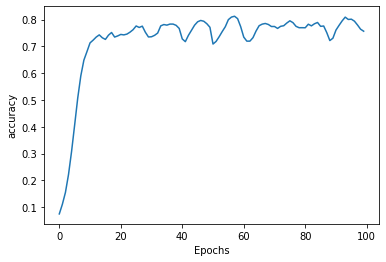

In [12]:
plot_graphs(history, 'accuracy')

##Test the model

In [13]:
seed_text = "I've got a bad feeling about this"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


I've got a bad feeling about this world i had fine do sportin in your eye id gone eyes eyes gone lass gone unprofaned gone gone alas i gone gone unprofaned right gone your eyes gone alas love beyond gone gone left your gone gone beyond the gone eyes are gone more inside yonder gone gone love gone gone gone forbid gone gone alas i gone gone love inside gone gone in gone gone gone by gone by a right gone gone mad love gone gone gone gone gone gone gone gone gone gone left gone gone and right gone gone gone gone gone gone gone gone
